In [55]:
# Libraries
# ==============================================================================
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from skforecast.datasets import fetch_dataset
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import TimeSeriesFold, backtesting_sarimax, grid_search_sarimax
from skforecast.plot import set_dark_theme
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

In [56]:
# Download data
# ==============================================================================
data = fetch_dataset(name="h2o_exog")
data.index.name = 'datetime'
data

h2o_exog
--------
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are
simulated.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,
https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (195, 3)


,y,exog_1,exog_2
datetime,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199
...,...,...,...
2008-02-01,0.761822,1.515840,1.786373
2008-03-01,0.649435,1.506258,1.694264
2008-04-01,0.827887,1.505253,1.627135


Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


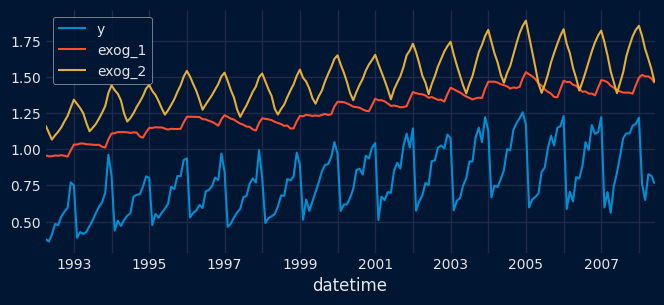

In [57]:
# Train-test dates
# ==============================================================================
end_train = '2005-06-01 23:59:59'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)
data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ==============================================================================
set_dark_theme()
fig, ax = plt.subplots(figsize=(7, 3))
data.plot(ax=ax)
ax.legend();

In [58]:
# ARIMA model with statsmodels.Sarimax
# ==============================================================================
arima = SARIMAX(endog = data_train['y'], order = (1, 1, 1))
arima_res = arima.fit(disp=0)
arima_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  159
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  89.934
Date:                Tue, 29 Apr 2025   AIC                           -173.869
Time:                        22:56:48   BIC                           -164.681
Sample:                    04-01-1992   HQIC                          -170.137
                         - 06-01-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6316      0.143      4.420      0.000       0.352       0.912
ma.L1         -0.9535      0.054    -17.815      0.000      -1.058      -0.849
sigma2         0.0186      0.002      8.619      0.000       0.014       0.023
===================================================================================
Ljung-Box (L1) (Q):                   0.75   Jarque-Bera (JB):               167.05
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               2.13   Skew:                            -1.66
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [59]:
# Prediction
# ==============================================================================
predictions = arima_res.get_forecast(steps=12)
predictions.predicted_mean.head(4)

2005-07-01    0.859454
2005-08-01    0.870312
2005-09-01    0.877170
2005-10-01    0.881502
Freq: MS, Name: predicted_mean, dtype: float64

In [60]:
# ARIMA model with skforecast.Sarimax
# ==============================================================================
arima = Sarimax(order=(1, 1, 1))
arima.fit(y=data_train['y'])
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  159
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  89.934
Date:                Tue, 29 Apr 2025   AIC                           -173.869
Time:                        22:56:48   BIC                           -164.681
Sample:                    04-01-1992   HQIC                          -170.137
                         - 06-01-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6316      0.143      4.420      0.000       0.352       0.912
ma.L1         -0.9535      0.054    -17.815      0.000      -1.058      -0.849
sigma2         0.0186      0.002      8.619      0.000       0.014       0.023
===================================================================================
Ljung-Box (L1) (Q):                   0.75   Jarque-Bera (JB):               167.05
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               2.13   Skew:                            -1.66
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
# Prediction
# ==============================================================================
predictions = arima.predict(steps=12)
predictions.head(4)

,pred
2005-07-01,0.859454
2005-08-01,0.870312
2005-09-01,0.877170
2005-10-01,0.881502


In [62]:
# Create and fit ForecasterSarimax
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(12, 1, 1), seasonal_order=(0, 0, 0, 0), maxiter=200),
             )

forecaster.fit(y=data_train['y'], suppress_warnings=True)
forecaster

================= 
ForecasterSarimax 
================= 
Regressor: Sarimax(12,1,1)(0,0,0)[0] 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'concentrate_scale': False, 'dates': None, 'disp': False,
    'enforce_invertibility': True, 'enforce_stationarity': True, 'freq': None,
    'hamilton_representation': False, 'maxiter': 200, 'measurement_error':
    False, 'method': 'lbfgs', 'missing': 'none', 'mle_regression': True,
    'order': (12, 1, 1), 'seasonal_order': (0, 0, 0, 0), 'simple_differencing':
    False, 'sm_fit_kwargs': {}, 'sm_init_kwargs': {}, 'sm_predict_kwargs': {},
    'start_params': None, 'time_varying_regression': False, 'trend': None,
    'trend_offset': 1, 'use_exact_diffuse': False, 'validate_specification':
    True} 
fit_kwargs: {} 
Creation date: 2025-04-29 22:56:48 
Last fit date: 2025-04-29 22:56:50 
Index seen by the forecaster: DatetimeIndex(['1992-04-01', '1992-05-01', '1992-06-01', '1992-07-01',
               '1992-08-01', '1992-09-01', '1992-10-01', '1992-11-01',
               '1992-12-01', '1993-01-01',
               ...
               '2004-09-01', '2004-10-01', '2004-11-01', '2004-12-01',
               '2005-01-01', '2005-02-01', '2005-03-01', '2005-04-01',
               '2005-05-01', '2005-06-01'],
              dtype='datetime64[ns]', name='datetime', length=159, freq='MS') 
Skforecast version: 0.15.1 
Python version: 3.13.3 
Forecaster id: None

In [63]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=36)
predictions.head(3)


2005-07-01    0.957912
2005-08-01    0.960098
2005-09-01    1.108658
Freq: MS, Name: pred, dtype: float64

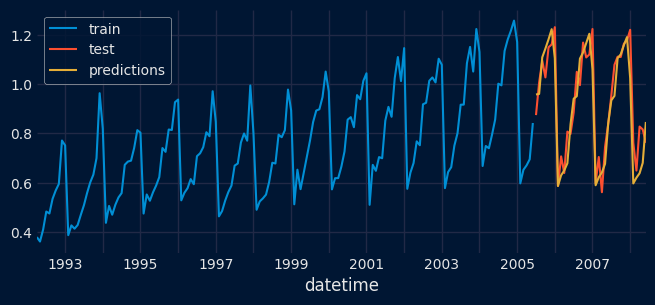

In [64]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [65]:
# Prediction error
# ==============================================================================
error_mse = mean_absolute_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.07123041759757585


In [66]:
# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(steps=36, alpha=0.05)
predictions.head(3)

,pred,lower_bound,upper_bound
2005-07-01,0.957912,0.857873,1.057952
2005-08-01,0.960098,0.853867,1.066329
2005-09-01,1.108658,0.998260,1.219057


In [67]:
# Create and fit ForecasterSarimax with exogenous variables
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(12, 1, 1), seasonal_order=(0, 0, 0, 0), maxiter=200),
             )

forecaster.fit(
    y                 = data_train['y'], 
    exog              = data_train[['exog_1', 'exog_2']],
    suppress_warnings = True
)

# Predict with exog
# ==============================================================================
predictions = forecaster.predict(
                  steps = 36,
                  exog  = data_test[['exog_1', 'exog_2']]
              )
predictions.head(3)

2005-07-01    0.903322
2005-08-01    0.930266
2005-09-01    1.087143
Freq: MS, Name: pred, dtype: float64

Train dates       : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Last window dates : 2005-07-01 00:00:00 --- 2006-06-01 00:00:00  (n=12)
Test dates        : 2006-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=24)


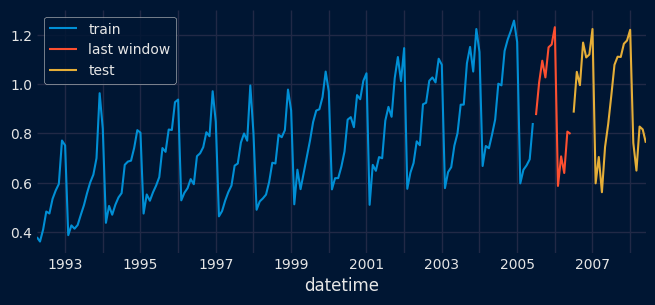

In [68]:
# Split data Train - Last window - Test
# ==============================================================================
end_train = '2005-06-01 23:59:59'
end_last_window = '2006-06-01 23:59:59'

print(
    f"Train dates       : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Last window dates : {data.loc[end_train:].index.min()} --- {data.loc[:end_last_window].index.max()}  "
    f"(n={len(data.loc[end_train:end_last_window])})"
)
print(
    f"Test dates        : {data.loc[end_last_window:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_last_window:])})"
)
data_train       = data.loc[:end_train]
data_last_window = data.loc[end_train:end_last_window]
data_test        = data.loc[end_last_window:]

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_last_window['y'].plot(ax=ax, label='last window')
data_test['y'].plot(ax=ax, label='test')
ax.legend();


In [69]:
# Create and fit ForecasterSarimax with exogenous variables
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(12, 1, 1), seasonal_order=(0, 0, 0, 0), maxiter=200),
             )

forecaster.fit(
    y                 = data_train['y'], 
    exog              = data_train[['exog_1', 'exog_2']],
    suppress_warnings = True
)

# Predict with exog and last window
# ==============================================================================
predictions = forecaster.predict(
                  steps            = 12,
                  exog             = data_test[['exog_1', 'exog_2']],
                  last_window      = data_last_window['y'],
                  last_window_exog = data_last_window[['exog_1', 'exog_2']]
              )
predictions.head(3)

2006-07-01    0.908101
2006-08-01    1.024210
2006-09-01    1.090153
Freq: MS, Name: pred, dtype: float64

In [70]:
# Prediction error
# ==============================================================================
error_mse = mean_absolute_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

ValueError: Found input variables with inconsistent numbers of samples: [24, 12]

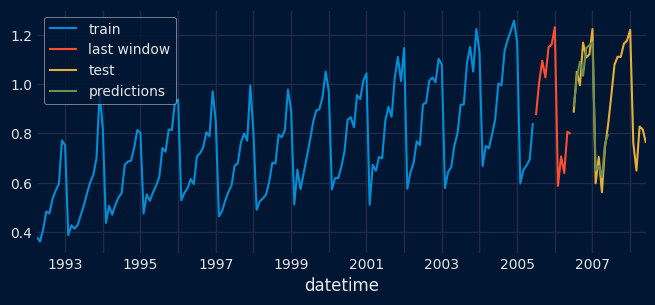

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_last_window['y'].plot(ax=ax, label='last window')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
# Feature importances
# ==============================================================================
forecaster.get_feature_importances()

,feature,importance
1,exog_2,1.550597
13,ar.L12,0.658619
15,sigma2,0.001592
12,ar.L11,-0.157033
2,ar.L1,-0.168776
6,ar.L5,-0.201032
4,ar.L3,-0.204531
7,ar.L6,-0.218175
10,ar.L9,-0.219698
9,ar.L8,-0.225288


In [ ]:
# Backtest forecaster
# ======================================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(12, 1, 1), seasonal_order=(0, 0, 0, 0), maxiter=200),
             )

cv = TimeSeriesFold(
         steps              = 12,
         initial_train_size = len(data_train),
         refit              = True,
         fixed_train_size   = False,
     )

metric, predictions = backtesting_sarimax(
                          forecaster            = forecaster,
                          y                     = data['y'],
                          exog                  = data[['exog_1', 'exog_2']],
                          cv                    = cv,
                          metric                = 'mean_absolute_error',
                          n_jobs                = 'auto',
                          suppress_warnings_fit = True,
                          verbose               = True,
                          show_progress         = True
                      )

metric

Information of folds
--------------------
Number of observations used for initial training: 159
Number of observations used for backtesting: 36
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 12
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2006-06-01 00:00:00  (n=12)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2006-06-01 00:00:00  (n=171)
    Validation: 2006-07-01 00:00:00 -- 2007-06-01 00:00:00  (n=12)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2007-06-01 00:00:00  (n=183)
    Validation: 2007-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=12)



100%|██████████| 3/3 [00:08<00:00,  2.91s/it]


,mean_absolute_error
0,0.056362


In [ ]:
# Backtest predictions
# ======================================================================================
predictions.head(4)

,pred
2005-07-01,0.903231
2005-08-01,0.931023
2005-09-01,1.087689
2005-10-01,1.113518


Train dates      : 1992-04-01 00:00:00 --- 2001-01-01 00:00:00  (n=106)
Validation dates : 2001-02-01 00:00:00 --- 2006-01-01 00:00:00  (n=60)
Test dates       : 2006-02-01 00:00:00 --- 2008-06-01 00:00:00  (n=29)


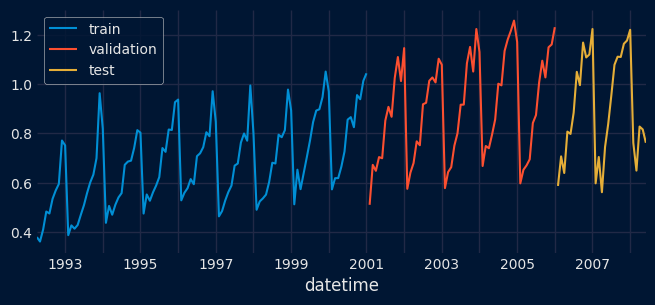

In [ ]:
# Train-validation-test data
# ======================================================================================
end_train = '2001-01-01 23:59:00'
end_val = '2006-01-01 23:59:00'

print(f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
print(f"Validation dates : {data.loc[end_train:].index.min()} --- {data.loc[:end_val].index.max()}  (n={len(data.loc[end_train:end_val])})")
print(f"Test dates       : {data.loc[end_val:].index.min()} --- {data.index.max()}  (n={len(data.loc[end_val:])})")

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train, 'y'].plot(ax=ax, label='train')
data.loc[end_train:end_val, 'y'].plot(ax=ax, label='validation')
data.loc[end_val:, 'y'].plot(ax=ax, label='test')
ax.legend();

In [ ]:
# Grid search hyperparameter
# ======================================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(12, 1, 1), maxiter=200)
             )

param_grid = {
    'order': [(12, 0, 0), (12, 1, 0), (12, 1, 1)],
    'trend': [None, 'n', 'c']
}

cv = TimeSeriesFold(
         steps              = 12,
         initial_train_size = len(data.loc[:end_train, 'y']),
         refit              = False
     )

results_grid = grid_search_sarimax(
                   forecaster            = forecaster,
                   y                     = data.loc[:end_val, 'y'],
                   param_grid            = param_grid,
                   cv                    = cv,
                   metric                = 'mean_absolute_error',
                   return_best           = True,
                   n_jobs                = 'auto',
                   suppress_warnings_fit = True,
                   verbose               = False,
                   show_progress         = True
               )

results_grid.head(5)

Number of models compared: 9.


params grid: 100%|██████████| 9/9 [00:17<00:00,  1.95s/it]


`Forecaster` refitted using the best-found parameters, and the whole data set: 
  Parameters: {'order': (12, 1, 0), 'trend': 'c'}
  Backtesting metric: 0.058789056979185204



,params,mean_absolute_error,order,trend
0,"{'order': (12, 1, 0), 'trend': 'c'}",0.058789,"(12, 1, 0)",c
1,"{'order': (12, 1, 1), 'trend': 'c'}",0.058949,"(12, 1, 1)",c
2,"{'order': (12, 1, 1), 'trend': 'n'}",0.059509,"(12, 1, 1)",n
3,"{'order': (12, 1, 1), 'trend': None}",0.059509,"(12, 1, 1)",None
4,"{'order': (12, 1, 0), 'trend': 'n'}",0.061719,"(12, 1, 0)",n


In [ ]:
forecaster

================= 
ForecasterSarimax 
================= 
Regressor: Sarimax(12,1,0)(0,0,0)[0] 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2006-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'concentrate_scale': False, 'dates': None, 'disp': False,
    'enforce_invertibility': True, 'enforce_stationarity': True, 'freq': None,
    'hamilton_representation': False, 'maxiter': 200, 'measurement_error':
    False, 'method': 'lbfgs', 'missing': 'none', 'mle_regression': True,
    'order': (12, 1, 0), 'seasonal_order': (0, 0, 0, 0), 'simple_differencing':
    False, 'sm_fit_kwargs': {}, 'sm_init_kwargs': {}, 'sm_predict_kwargs': {},
    'start_params': None, 'time_varying_regression': False, 'trend': 'c',
    'trend_offset': 1, 'use_exact_diffuse': False, 'validate_specification':
    True} 
fit_kwargs: {} 
Creation date: 2025-04-29 20:51:52 
Last fit date: 2025-04-29 20:52:13 
Index seen by the forecaster: DatetimeIndex(['1992-04-01', '1992-05-01', '1992-06-01', '1992-07-01',
               '1992-08-01', '1992-09-01', '1992-10-01', '1992-11-01',
               '1992-12-01', '1993-01-01',
               ...
               '2005-04-01', '2005-05-01', '2005-06-01', '2005-07-01',
               '2005-08-01', '2005-09-01', '2005-10-01', '2005-11-01',
               '2005-12-01', '2006-01-01'],
              dtype='datetime64[ns]', name='datetime', length=166, freq='MS') 
Skforecast version: 0.15.1 
Python version: 3.13.3 
Forecaster id: None

In [ ]:
# Create and fit ForecasterSarimax (skforecast)
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(12, 1, 1), maxiter=200),
             )
forecaster.fit(y=data_train['y'], suppress_warnings=True)

# In-sample Predictions
# ==============================================================================
forecaster.regressor.sarimax_res.fittedvalues

datetime
1992-04-01    0.000000
1992-05-01    0.379808
1992-06-01    0.361407
1992-07-01    0.413161
1992-08-01    0.480841
                ...   
2005-02-01    0.739206
2005-03-01    0.751108
2005-04-01    0.716067
2005-05-01    0.749942
2005-06-01    0.817516
Freq: MS, Length: 159, dtype: float64